## **Sesgos en Modelos de Embeddings -  Procesamiento de Lenguaje Natural**

-----------------------------

##### Importando Librerías

In [1]:
import random
import gensim
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

##### Cargando el Modelo

In [2]:
model = gensim.models.KeyedVectors.load_word2vec_format('/Users/constanzaneiraurrutia/Desktop/ESCRITORIO/MAGÍSTER DATA SCIENCE/QUINTO TRIMESTRE/PROCESAMIENTO DE LENGUAJE NATURAL/NOTEBOOKS/NOTEBOOKS CLASE 4/sbw_vectors.bin', binary=True)

### 1. Funciones para Cálculo de WEAT Score

In [3]:
# Función para calcular la distancia de coseno.
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

# Función para calcular la asociación.
def association(word, attribute_words):
    return np.mean([cosine_similarity(model[word], model[attr_word]) for attr_word in attribute_words])

# Función para calcular el puntaje WEAT.
def weat_score(target_1, target_2, attributes_1, attributes_2):
    target_1_assoc = [association(word, attributes_1) - association(word, attributes_2) for word in target_1]
    target_2_assoc = [association(word, attributes_1) - association(word, attributes_2) for word in target_2]
    return np.mean(target_1_assoc) - np.mean(target_2_assoc)

# Función para calcular la prueba de permutación y el p-value.
def permutation_test(target_1, target_2, attributes_1, attributes_2, num_permutations=10000):
    observed_score = weat_score(target_1, target_2, attributes_1, attributes_2)
    combined = target_1 + target_2
    permuted_scores = []
    
    for _ in range(num_permutations):
        random.shuffle(combined)
        permuted_target_1 = combined[:len(target_1)]
        permuted_target_2 = combined[len(target_1):]
        permuted_score = weat_score(permuted_target_1, permuted_target_2, attributes_1, attributes_2)
        permuted_scores.append(permuted_score)
    
    p_value = sum(1 for x in permuted_scores if abs(x) >= abs(observed_score)) / num_permutations
    return observed_score, p_value

### 2. WEAT Score para Emociones y Género

In [4]:
# Listas de palabras específicas para grupo de emociones y género.
nombres_masculinos = ['hombre', 'masculino', 'él', 'varón']
nombres_femeninos = ['mujer', 'femenino', 'ella', 'dama']
emociones_positivas = ['amor', 'sensibilidad', 'fortaleza', 'prudencia', 'inteligencia', 'confianza', 'alegría', 'tolerancia','felicidad', 'sorpresa']
emociones_negativas = ['rabia', 'irritabilidad', 'tristeza', 'miedo', 'ansiedad', 'angustia', 'ira']

In [5]:
# Cálculo del puntaje WEAT.
score = weat_score(nombres_masculinos, nombres_femeninos, emociones_negativas, emociones_positivas)
print(f'WEAT Score (Emociones y Género): {score}')

WEAT Score (Emociones y Género): 0.012904662638902664


In [6]:
# Cálculo de p-value.
p_value = permutation_test(nombres_masculinos, nombres_femeninos, emociones_negativas, emociones_positivas)
print(f'WEAT Score y p-value: {p_value}')

WEAT Score y p-value: (0.012904663, 0.7929)


#### 2.1 Interpretación WEAT Score Emociones y Género


El valor del WEAT Score, que indica la magnitud del sesgo medido por la métrica WEAT, fue de 0.012904663, evidenciando una pequeña diferencia en la asociación de palabras de emociones negativas y positivas con nombres masculinos y femeninos, sin embargo, dicha diferencia no fue estadísticamente significativa (p-value 0.7929), por lo que no hay suficiente evidencia para concluir que existe un sesgo significativo en las asociaciones de género para las emociones negativas y positivas.

In [7]:
# Creación de variables.
present_traits = emociones_positivas + emociones_negativas

# Cálculo de las puntuaciones de asociación individuales.
individual_weat_scores = {word: association(word, nombres_masculinos) - association(word, nombres_femeninos) for word in present_traits}

# Creación de un DataFrame para las puntuaciones de asociación individuales.
individual_weat_df = pd.DataFrame(list(individual_weat_scores.items()), columns=['Trait', 'WEAT Association Score'])

# Visualización del resultado en una tabla.
display(individual_weat_df)

,Trait,WEAT Association Score
0,amor,-0.030489
1,sensibilidad,-0.011670
2,fortaleza,-0.032012
3,prudencia,0.014361
4,inteligencia,0.013691
5,confianza,0.031475
6,alegría,-0.013746
7,tolerancia,0.010308
8,felicidad,-0.007316
9,sorpresa,-0.045622


#### 2.2 Interpretación Puntuaciones Individuales Emociones y Género

En la tabla anterior se puede observar las puntuaciones de asociación para cada emoción con los atributos de género utilizando la métrica WEAT.

Las puntuaciones negativas indican que las emociones están más asociadas con atributos femeninos que con atributos masculinos. Por ejemplo, amor (-0.030489) tiene una asociación negativa moderada, lo que sugiere una tendencia a estar más relacionada con atributos femeninos, al igual que fortaleza. Sorpresa (-0.045622) es la emoción con la asociación negativa más fuerte, indicando una mayor conexión con atributos femeninos.

Las puntuaciones positivas indican que las emociones están más asociadas con atributos masculinos. Por ejemplo, prudencia (0.014361) tiene una ligera asociación con atributos masculinos, al igual que inteligencia. Confianza (0.031475) es la emoción que tiene una asociación positiva más notable, sugiriendo una relación con atributos masculinos.

Las puntuaciones cercanas a cero indican que la emoción no tiene una fuerte asociación con ninguno de los géneros, como irritabilidad (0.000873) y angustia (0.004678).

#### 2.3 Visualización Puntuaciones Emociones y Género

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


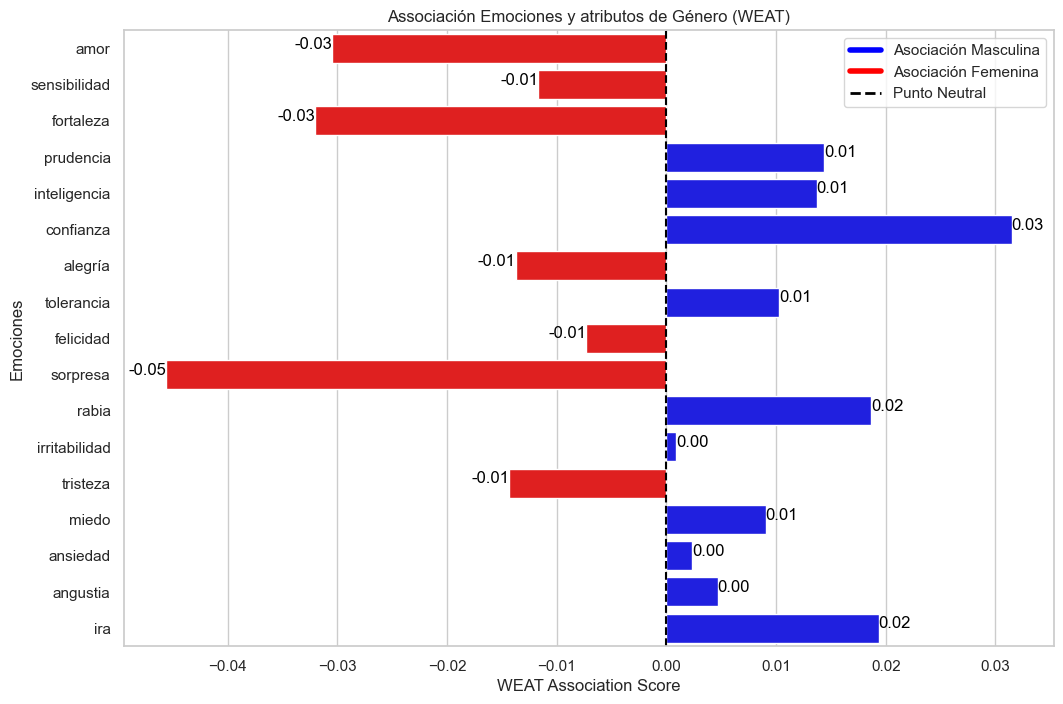

In [8]:
# Definición de paleta de colores intuitiva: azul para masculino, rojo para femenino.
colors = ["blue" if value > 0 else "red" for value in individual_weat_df["WEAT Association Score"]]

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Creación el gráfico de barras con colores personalizados.
barplot = sns.barplot(x="WEAT Association Score", y="Trait", data=individual_weat_df, palette=colors, orient="h")

# Etiquetación de barras.
for index, value in enumerate(individual_weat_df["WEAT Association Score"]):
    barplot.text(value, index, f'{value:.2f}', color='black', ha="left" if value > 0 else "right")

# Línea de referencia para el punto neutral.
plt.axvline(0.0, color='black', linestyle='--', label='Neutral Point')

# Creación de leyenda personalizada.
legend_elements = [Line2D([0], [0], color='blue', lw=4, label='Asociación Masculina'),
                   Line2D([0], [0], color='red', lw=4, label='Asociación Femenina'),
                   Line2D([0], [0], color='black', lw=2, linestyle='--', label='Punto Neutral')]

plt.legend(handles=legend_elements)

# Etiquetas y título.
plt.xlabel('WEAT Association Score')
plt.ylabel('Emociones')
plt.title('Associación Emociones y atributos de Género (WEAT)')
plt.show()

### 3. WEAT Score para Profesiones y Género

In [9]:
# Listas de palabras específicas para profesión y género.
nombres_masculinos = ['hombre', 'masculino', 'él', 'varón']
nombres_femeninos = ['mujer', 'femenino', 'ella', 'dama']
profesiones_masculinas = ['enfermero','ingeniero', 'maestro', 'doctor', 'arquitecto', 'programador', 'presidente']
profesiones_femeninas = ['enfermera', 'doctora', 'ingeniera','maestra', 'secretaria', 'niñera', 'presidenta']


In [10]:
# Cálculo del puntaje WEAT.
score = weat_score(nombres_masculinos, nombres_femeninos, profesiones_masculinas, profesiones_femeninas)
print(f'WEAT Score (Profesión y Género): {score}')

WEAT Score (Profesión y Género): 0.1860462725162506


In [11]:
# Cálculo del p-value.
p_value = permutation_test(nombres_masculinos, nombres_femeninos, profesiones_masculinas, profesiones_femeninas)

print(f'WEAT Score y p-value: {p_value}')

WEAT Score y p-value: (0.18604627, 0.0287)


#### 3.1 Interpretación WEAT Score Profesiones y Género

El valor del WEAT Score fue de 0.18604627, evidenciando que existe una diferencia en la asociación de profesiones masculinas y femeninas con los atributos de género masculinos y femeninos. Pese a que este valor fue relativamente pequeño o "debil", la diferencia observada fue estadísticamente significativa (p-value 0.0287), lo que indica que existe evidencia para rechazar la hipótesis nula y permite afirmar que existe un sesgo significativo en las asociaciones de género con las profesiones analizadas.

In [12]:
# Creación de variable.
present_traits = profesiones_femeninas + profesiones_masculinas

# Cálculo de las puntuaciones de asociación individuales.
individual_weat_scores = {word: association(word, nombres_masculinos) - association(word, nombres_femeninos) for word in present_traits}

# Creación de DataFrame para las puntuaciones de asociación.
individual_weat_df = pd.DataFrame(list(individual_weat_scores.items()), columns=['Trait', 'WEAT Association Score'])

# Visualización del resultado en una tabla.
display(individual_weat_df)

,Trait,WEAT Association Score
0,enfermera,-0.122018
1,doctora,-0.110895
2,ingeniera,-0.124189
3,maestra,-0.143002
4,secretaria,-0.171601
5,niñera,-0.112041
6,presidenta,-0.207132
7,enfermero,0.050317
8,ingeniero,0.046775
9,maestro,0.052127


#### 3.2 Interpretación Puntuaciones Individuales Profesiones y Género

En base a los resultados obtenidos se puede observar que hay profesiones que están más asociadas con atributos femeninos que con atributos masculinos (las que presentan puntuaciones negativas), como presidenta (-0.207132), secretaria (-0.171601), maestra (-0.143002), enfermera (-0.122018), y hay otras profesiones más asociadas con atributos masculinos (las que presentan puntuaciones positivas), como doctor (0.069109), programador (0.056629), maestro (0.052127), arquitecto (0.049379), lo que podría sugerir la presencia de estereotipo de género asociado a estas profesiones, donde se refleja que ciertas profesiones son vistas como más femeninas mientras que otras son vistas como más masculinas.

#### 3.3 Visualización Puntuaciones Profesiones y Género

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


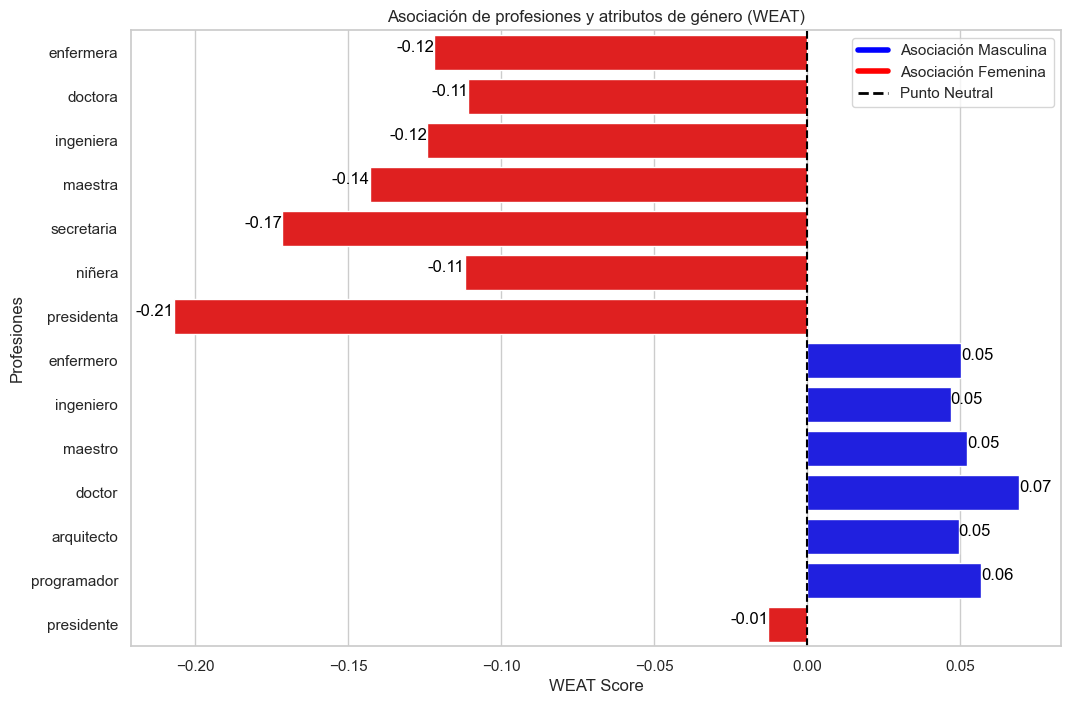

In [13]:
# Definición de paleta de colores intuitiva: azul para masculino, rojo para femenino.
colors = ["blue" if value > 0 else "red" for value in individual_weat_df["WEAT Association Score"]]

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Creación de gráfico de barras.
barplot = sns.barplot(x="WEAT Association Score", y="Trait", data=individual_weat_df, palette=colors, orient="h")

# Etiquetación de las barras.
for index, value in enumerate(individual_weat_df["WEAT Association Score"]):
    barplot.text(value, index, f'{value:.2f}', color='black', ha="left" if value > 0 else "right")

# Línea de referencia para el punto neutral.
plt.axvline(0.0, color='black', linestyle='--', label='Neutral Point')

# Creación de leyenda personalizada.
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='blue', lw=4, label='Asociación Masculina'),
                   Line2D([0], [0], color='red', lw=4, label='Asociación Femenina'),
                   Line2D([0], [0], color='black', lw=2, linestyle='--', label='Punto Neutral')]

plt.legend(handles=legend_elements)

# Etiquetas y título.
plt.xlabel('WEAT Score')
plt.ylabel('Profesiones')
plt.title('Asociación de profesiones y atributos de género (WEAT)')
plt.show()
